In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from utils import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import defaultdict
import numpy as np
import matplotlib.cm as cm

### Figure 1: Showing the start up time of vLLM for different versions using OPT-6.7B model

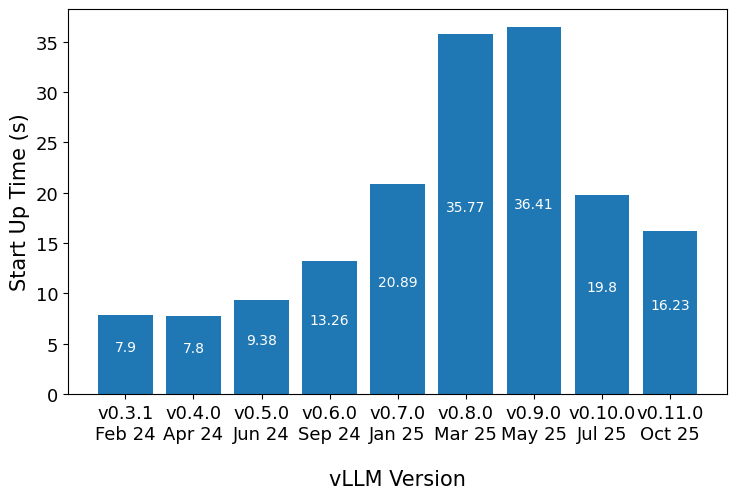

In [ ]:
import matplotlib.pyplot as plt
import json

with open("examples/versions/avg_comparison_results.json", "r") as f:
    data = json.load(f)
    
labels = [label.split("_")[-1].split(".txt")[0] for label in data["labels"]]
values = [round(value, 2) for value in data["data"]["actual_total_time"]]
release_dates = ["Feb 24", "Apr 24", "Jun 24", "Sep 24", "Jan 25", "Mar 25", "May 25", "Jul 25", "Oct 25"]

plt.figure(figsize=(8.5, 5))
bars = plt.bar([f"{l}\n{release_dates[i]}\n" for i,l in enumerate(labels)], values)
plt.ylabel("Start Up Time (s)", fontsize=15)
plt.xlabel("vLLM Version", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{value}', ha='center', va='bottom', fontsize=10, color="white")

plt.savefig(
    "figures/vllm-version-startuptime.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Figure 2: vLLM startup process breakdown

/tmp/ipykernel_860198/1364930919.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


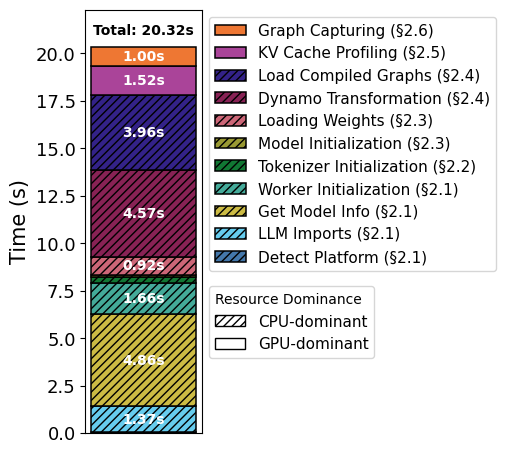

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step Information ---
steps = [
    ("Detect Platform (§2.1)", 0.034, "CPU"),
    ("LLM Imports (§2.1)", 1.371, "CPU"),
    ("Get Model Info (§2.1)", 4.863, "CPU"),
    ("Worker Initialization (§2.1)", 1.659, "CPU"),
    ("Tokenizer Initialization (§2.2)", 0.29, "CPU"),
    ("Model Initialization (§2.3)", 0.13, "CPU"),
    ("Loading Weights (§2.3)", 0.92, "CPU"),
    ("Dynamo Transformation (§2.4)", 4.57, "CPU"),
    ("Load Compiled Graphs (§2.4)", 3.96, "CPU"),
    ("KV Cache Profiling (§2.5)", 1.52, "GPU"),
    ("Graph Capturing (§2.6)", 1.00, "GPU"),
]

# --- Assign Distinct Colors (color-blind friendly palette) ---
step_colors = [
    "#4477AA", "#66CCEE", "#CCBB44", "#44AA99",
    "#117733", "#999933", "#CC6677", "#882255", 
    "#332288", "#AA4499", "#EE7733"
]

# --- Prepare Data ---
labels = [s[0] for s in steps]
times = [s[1] for s in steps]
types = [s[2] for s in steps]
total_time = sum(times)

# --- Compute cumulative bottoms for stacking ---
bottoms = np.cumsum([0] + times[:-1])

# --- Plot ---
fig, ax = plt.subplots(figsize=(1.5, 5.5))

# Draw stacked bar (with hatch for CPU)
bars = []
for i, (label, time, typ, bottom, color) in enumerate(zip(labels, times, types, bottoms, step_colors)):
    hatch = (
    '////' if typ == 'CPU' else
    ''
)
    b = ax.bar("Startup", time, bottom=bottom, color=color, edgecolor="black", hatch=hatch, linewidth=1.1)
    bars.append(b[0])
    if time >= 0.5:
        ax.text(0, bottom + time / 2, f"{time:.2f}s", ha="center", va="center",
                color="white", fontsize=10, fontweight="bold")

# --- Annotate Total ---
ax.text(0, total_time + 0.5, f"Total: {total_time:.2f}s", ha="center", va="bottom",
        fontsize=10, fontweight="bold")

# --- Styling ---
ax.set_ylim(0, total_time + 2)
ax.set_ylabel("Time (s)", fontsize=15)
ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
ax.tick_params(axis="y", labelsize=13)

# --- Legend for Steps ---
from matplotlib.patches import Patch
dep_patches = [
    Patch(facecolor='white', edgecolor='black', hatch='////', label='CPU-dominant'),
    Patch(facecolor='white', edgecolor='black', label='GPU-dominant')
]
dep_legend = ax.legend(
    dep_patches, [p.get_label() for p in dep_patches],
    loc='upper right',
    bbox_to_anchor=(2.5, 0.35),
    fontsize=11,
    title="Resource Dominance",
    frameon=True,
    borderaxespad=0.1,
    alignment="left"
)

# --- Legend for CPU/GPU dependency ---

ax.add_artist(dep_legend)
ax.legend(
    bars[::-1],
    labels[::-1],
    loc="upper right",
    bbox_to_anchor=(3.6, 1),
    fontsize=11,
    frameon=True,
    borderaxespad=0.5,
    alignment="left"
)

plt.tight_layout()
plt.savefig(
        f"figures/vllm-init.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
plt.show()


### Figure 2: LLM requests are bursty

trace_kalos.csv: CV=0.987, Peak/Average=20.31


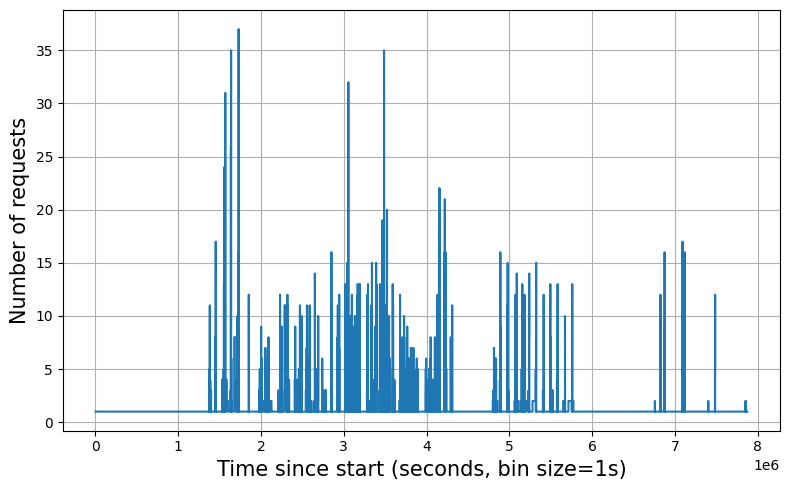

qwen_traceA_blksz_16.jsonl: CV=0.453, Peak/Average=2.99


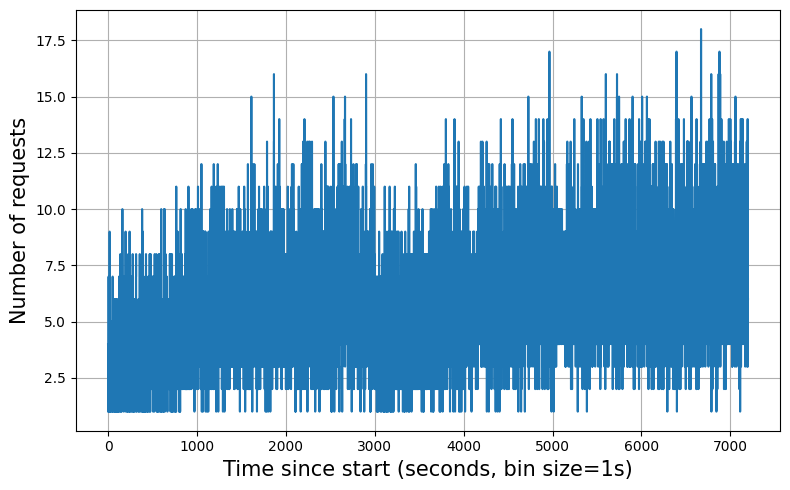

qwen_traceB_blksz_16.jsonl: CV=0.275, Peak/Average=2.17


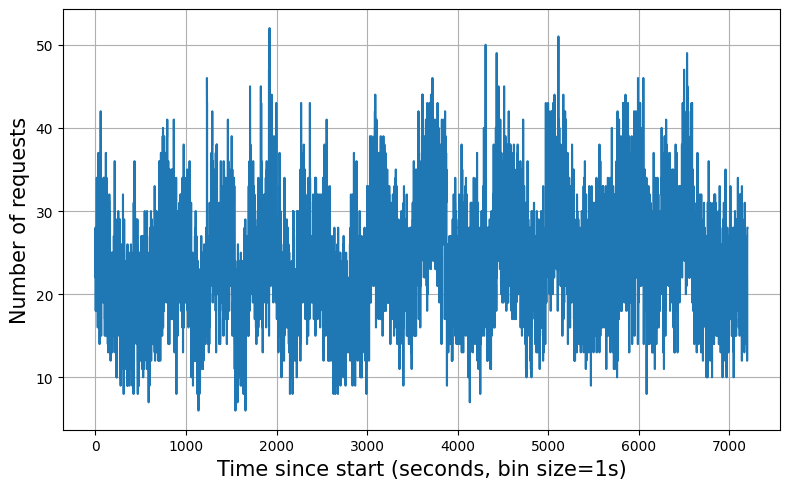

In [66]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def draw_traces(trace_files, filename, is_ms=True):
    bin_size = 1  # seconds per bin (adjust as needed)

    plt.figure(figsize=(8, 5))

    for file in trace_files:
        if file.endswith(".jsonl"):
            timestamps = []
            with open(file, "r") as f:
                for line in f:
                    data = json.loads(line)
                    timestamps.append(data["timestamp"])

            # Skip empty files
            if not timestamps:
                continue

            # Sort timestamps and normalize (convert to seconds & start from 0)
            timestamps.sort()
            timestamps = [t / 1000.0 if is_ms else t for t in timestamps]  # ms → sec
            start_time = timestamps[0]
            timestamps = [t - start_time for t in timestamps]  # relative time
            
            # Bin timestamps into fixed intervals
            binned = [int(t // bin_size) for t in timestamps]
            counts = Counter(binned)

            # Prepare data for plotting
            x = sorted(counts.keys())
            y = [counts[i] for i in x]

            # Calculate metrics
            y_arr = np.array(y)
            mean_y = np.mean(y_arr)
            std_y = np.std(y_arr)
            cv = std_y / mean_y if mean_y != 0 else float('nan')
            peak_to_avg = np.max(y_arr) / mean_y if mean_y != 0 else float('nan')
            print(f"{os.path.basename(file)}: CV={cv:.3f}, Peak/Average={peak_to_avg:.2f}")

            label = os.path.basename(file).replace(".jsonl", "")
            plt.plot(x, y, drawstyle="steps-mid", label=f"{label} (CV={cv:.2f}, P/A={peak_to_avg:.1f})")
        elif file.endswith(".csv"):
            time_column = "submit_time" # or "start_time"
            df = pd.read_csv(file, parse_dates=[time_column])
        
            # Convert to timestamps in seconds since start
            timestamps = (df[time_column] - df[time_column].min()).dt.total_seconds()
            timestamps = timestamps.dropna().sort_values()

            # Bin into intervals
            binned = (timestamps // bin_size).astype(int)
            counts = Counter(binned)

            x = sorted(counts.keys())
            y = [counts[i] for i in x]

            # Calculate metrics
            y_arr = np.array(y)
            mean_y = np.mean(y_arr)
            std_y = np.std(y_arr)
            cv = std_y / mean_y if mean_y != 0 else float('nan')
            peak_to_avg = np.max(y_arr) / mean_y if mean_y != 0 else float('nan')
            print(f"{os.path.basename(file)}: CV={cv:.3f}, Peak/Average={peak_to_avg:.2f}")

            label = file.split("/")[-1].replace(".csv", "")
            plt.plot(x, y, drawstyle="steps-mid", label=f"{label} (CV={cv:.2f}, P/A={peak_to_avg:.1f})")

    # === Styling ===
    plt.xlabel(f"Time since start (seconds, bin size={bin_size}s)", fontsize=15)
    plt.ylabel("Number of requests", fontsize=15)
    # plt.title("LLM Inference Request Burstiness Over Time")
    plt.grid(True)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()
    
# draw_traces(["./traces/conversation_trace.jsonl"], "mooncake-trace")
# draw_traces(["./traces/toolagent_trace.jsonl"], "mooncake-trace")
draw_traces(["./traces/trace_kalos.csv"], "shangahi-trace")
# draw_traces(["./traces/trace_seren.csv"], "shangahi-trace")
draw_traces(["./traces/qwen_traceA_blksz_16.jsonl"], "alibaba-trace", False)
draw_traces(["./traces/qwen_traceB_blksz_16.jsonl"], "alibaba-trace", False)

### Figure 3: Showing the relationship between tokenizer initialization and size

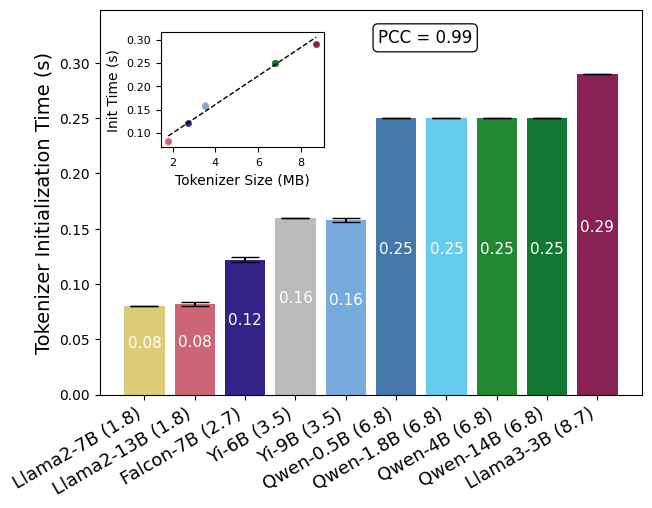

In [2]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "falcon-7b": "Falcon-7B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "llama3-3b": "Llama3-3B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "tokenizer_init"
metric2 = "tokenizer_size"
xlabel = ""
ylabel = "Tokenizer Initialization Time (s)"
x2label = "Tokenizer Size (MB)"
y2label = "Init Time (s)"
ylim_multiplier = 1.2
filename = "figures/init-tokenizer-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 4: Showing the relationship between loading weights and model size

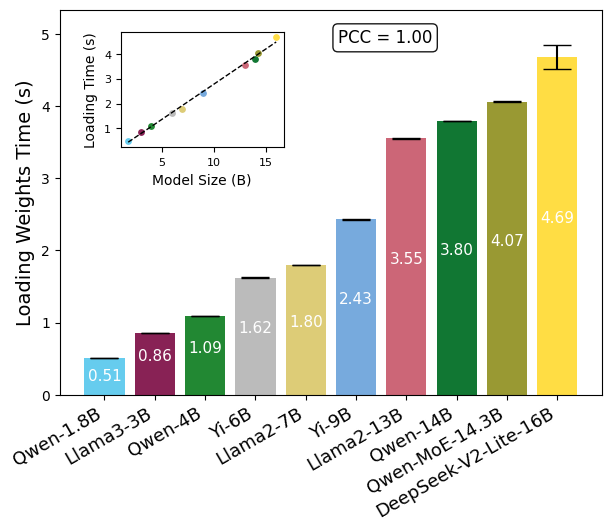

In [3]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "load_weights"
metric2 = "size"
xlabel = ""
ylabel = "Loading Weights Time (s)"
x2label = "Model Size (B)"
y2label = "Loading Time (s)"
ylim_multiplier = 1.1
filename = "figures/load-weights-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 5: Showing the relationship between dynamo bytcode transform and number of layers

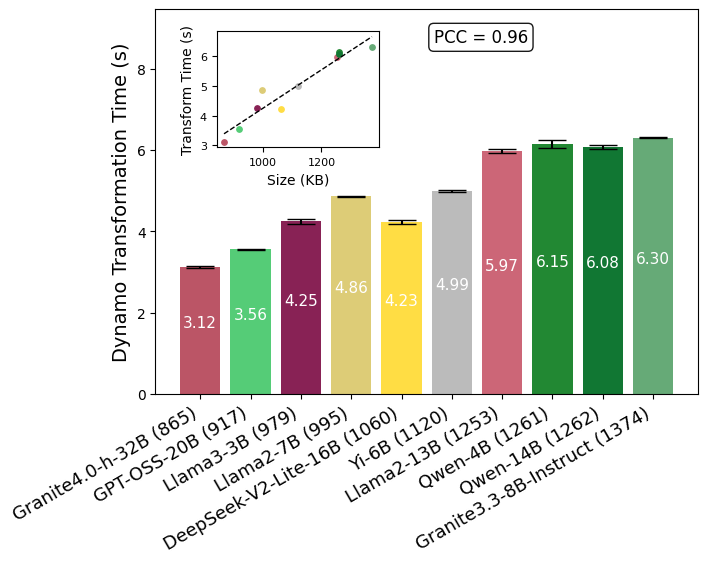

In [4]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B",
    "granite3.3-8b-instruct": "Granite3.3-8B-Instruct",
    "granite4.0-h-32b": "Granite4.0-h-32B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "dynamo_transform_time"
metric2 = "compiled_graph_sizes"
xlabel = ""
ylabel = "Dynamo Transformation Time (s)"
x2label = "Size (KB)"
y2label = "Transform Time (s)"
ylim_multiplier = 1.5
filename = "figures/dynamo-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 6: Showing the relationship between loading compile graph and number of layers

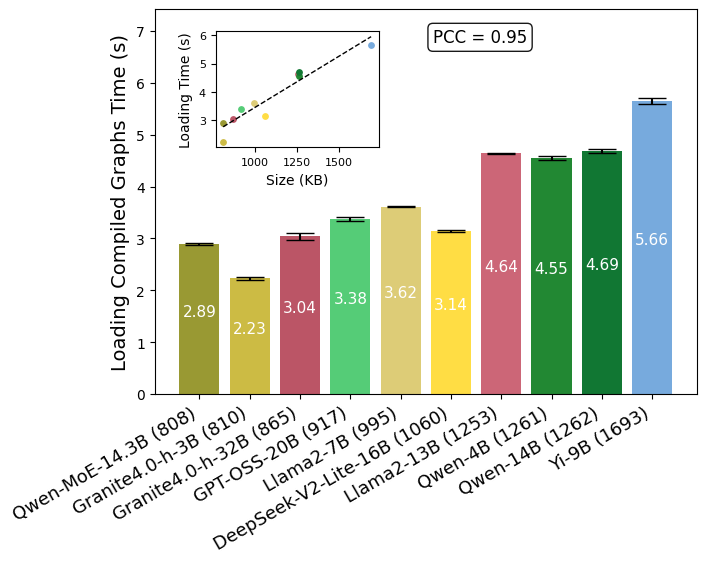

In [5]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B",
    "granite4.0-h-32b": "Granite4.0-h-32B",
    "granite4.0-h-3b": "Granite4.0-h-3B"
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "graph_compile_cached"
metric2 = "compiled_graph_sizes"
xlabel = ""
ylabel = "Loading Compiled Graphs Time (s)"
x2label = "Size (KB)"
y2label = "Loading Time (s)"
ylim_multiplier = 1.3
filename = "figures/load-graphs-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 7: Showing the relationship between KV cache profiling and model size

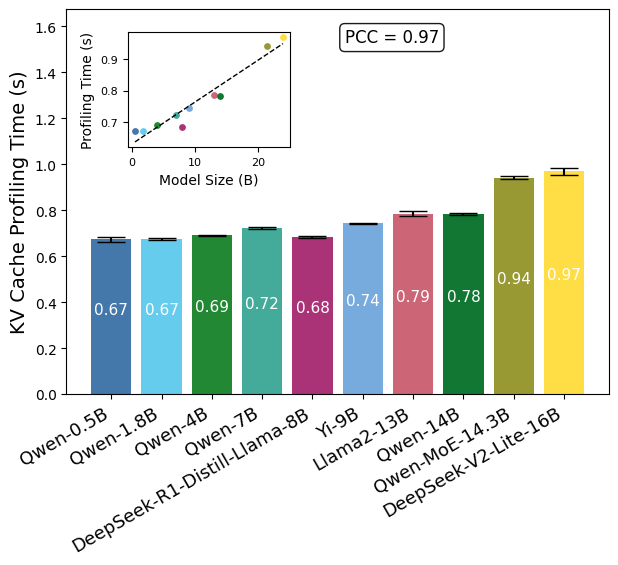

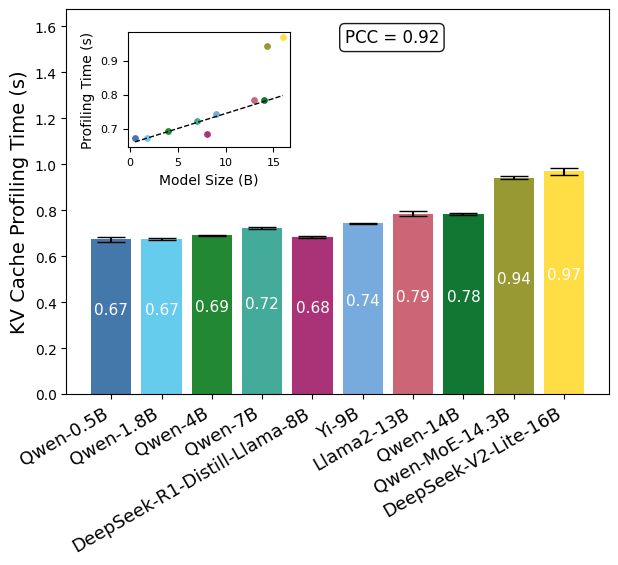

In [6]:
model_names_map = {
    "llama2-13b-hf": "Llama2-13B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-7b": "Qwen-7B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    # "llama3-3b": "Llama3-3B",
    # "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    # "deepseek-r1-distill-qwen-7b": "DeepSeek-R1-Distill-Qwen-7B",
    "deepseek-r1-distill-llama-8b": "DeepSeek-R1-Distill-Llama-8B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    # "falcon-7b": "Falcon-7B",
}
iterations_path = "examples/kv_cache_profiling/iterations"
sort_by = "model_size"
metric1 = "kv_cache_profiling"
metric2 = "size"
xlabel = ""
ylabel = "KV Cache Profiling Time (s)"
x2label = "Model Size (B)"
y2label = "Profiling Time (s)"
ylim_multiplier = 1.7
filename = "figures/kv-cache-results"
func = extract_kv_cache_profiling_overhead
excluded_models = ['Qwen-MoE-14.3B', 'DeepSeek-V2-Lite-16B']
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func)


iterations_path = "examples/kv_cache_profiling/iterations"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, excluded_labels=excluded_models)

### Figure 8: Showing the relationship between graph capturing and model size

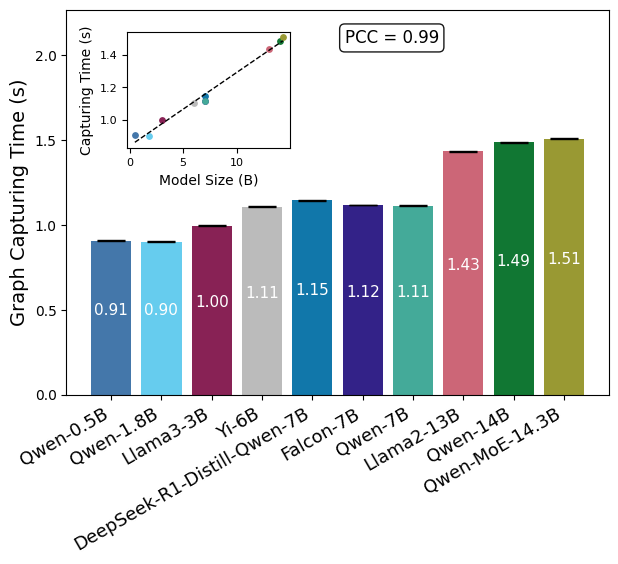

In [7]:
model_names_map = {
    "llama2-13b-hf": "Llama2-13B",
    "falcon-7b": "Falcon-7B",
    "yi-6b": "Yi-6B",
    "qwen-0.5b": "Qwen-0.5B",
    "qwen-1.8b": "Qwen-1.8B",
    "qwen-7b": "Qwen-7B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-r1-distill-qwen-7b": "DeepSeek-R1-Distill-Qwen-7B",
}
iterations_path = "examples/model_size/iterations"
sort_by = "model_size"
metric1 = "graph_capturing"
metric2 = "size"
xlabel = ""
ylabel = "Graph Capturing Time (s)"
x2label = "Model Size (B)"
y2label = "Capturing Time (s)"
ylim_multiplier = 1.5
filename = "figures/cuda-graph-model-size"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

### Figure 9: Showing the relationship between graph capturing and number of batch sizes

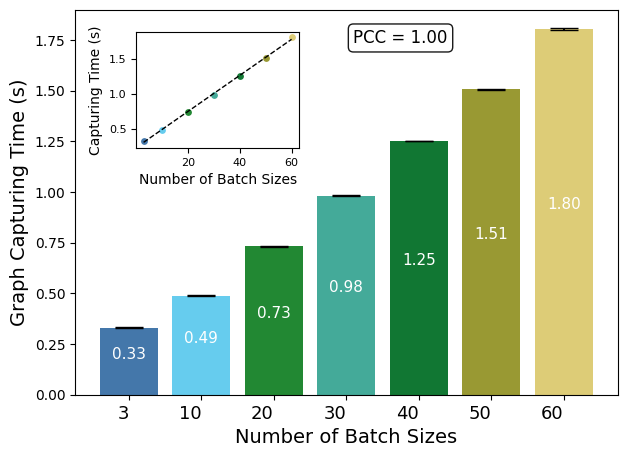

In [8]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
}
iterations_path = "examples/batch_size2/iterations"
sort_by = "model_size"
metric1 = "graph_capturing"
metric2 = "size"
xlabel = "Number of Batch Sizes"
ylabel = "Graph Capturing Time (s)"
x2label = "Number of Batch Sizes"
y2label = "Capturing Time (s)"
ylim_multiplier = 1.05
filename = "figures/cuda-graph-batch-size"
func = extract_batch_size
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename, func)

### Figure 11: Validation of the predictor 

/local/huzaifa/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/local/huzaifa/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/local/huzaifa/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.7.1. 

[np.float64(1.679608491634113), np.float64(0.8811744356751632), np.float64(1.827014904586452), np.float64(2.0816351587624062), np.float64(0.9268260607792307)]
Mean Squared Error (MSE): 2.4255


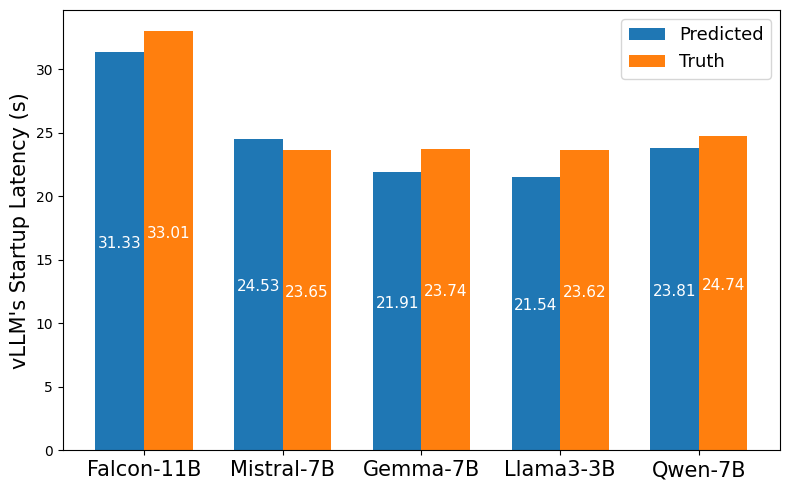

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from predictor.run_predictor import predict

model_names_map = {
    "falcon-11b": "Falcon-11B",
    "mistral-7b": "Mistral-7B",
    "gemma-7b": "Gemma-7B",
    "llama3-3b": "Llama3-3B",
    "qwen-7b": "Qwen-7B",
}

results = predict("predictor_info/models", "predictor_info/test_data.json")["validation"]

# Data
models = []
predicted = []
truth = []
diff = []
for x in results:
    label = x["label"]
    if label in model_names_map:
        models.append(model_names_map[label])
        predicted.append(x["predicted"])
        truth.append(x["truth"])
        diff.append(x["diff"])

print(diff)   
actual = np.array(truth)
predictions = np.array(predicted)
mse = np.mean((actual - predictions) ** 2)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")

x = np.arange(len(models))
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(8, 5))

# Bars: Predicted vs Truth
bars1 = ax1.bar(x - width/2, predicted, width, label="Predicted")
bars2 = ax1.bar(x + width/2, truth, width, label="Truth")

for bar in bars1 + bars2:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=11, color='white')

ax1.set_ylabel("vLLM's Startup Latency (s)", fontsize=15)
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=15)
ax1.legend(fontsize=13)

plt.tight_layout()
plt.savefig(
    "figures/predictor-validation.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()


### Figure 10: Impact of Different GPU (Node 5 vs Node 7)

{'tokenizer_init': [{'model_name': 'falcon-7b', 'value1': 0.122, 'value2': 0.12, 'speedup': 0.9836065573770492}, {'model_name': 'llama2-13b-hf', 'value1': 0.082, 'value2': 0.08, 'speedup': 0.975609756097561}, {'model_name': 'llama2-7b-hf', 'value1': 0.08, 'value2': 0.08, 'speedup': 1.0}, {'model_name': 'llama3-3b', 'value1': 0.29, 'value2': 0.28400000000000003, 'speedup': 0.9793103448275864}, {'model_name': 'qwen-0.5b', 'value1': 0.25, 'value2': 0.248, 'speedup': 0.992}, {'model_name': 'qwen-14b', 'value1': 0.25, 'value2': 0.246, 'speedup': 0.984}, {'model_name': 'qwen-1.8b', 'value1': 0.25, 'value2': 0.248, 'speedup': 0.992}, {'model_name': 'qwen-4b', 'value1': 0.25, 'value2': 0.25, 'speedup': 1.0}, {'model_name': 'qwen-7b', 'value1': 0.25, 'value2': 0.248, 'speedup': 0.992}, {'model_name': 'yi-6b', 'value1': 0.16, 'value2': 0.154, 'speedup': 0.9625}, {'model_name': 'yi-9b', 'value1': 0.158, 'value2': 0.15, 'speedup': 0.9493670886075949}], 'model_init': [{'model_name': 'falcon-7b', 'v

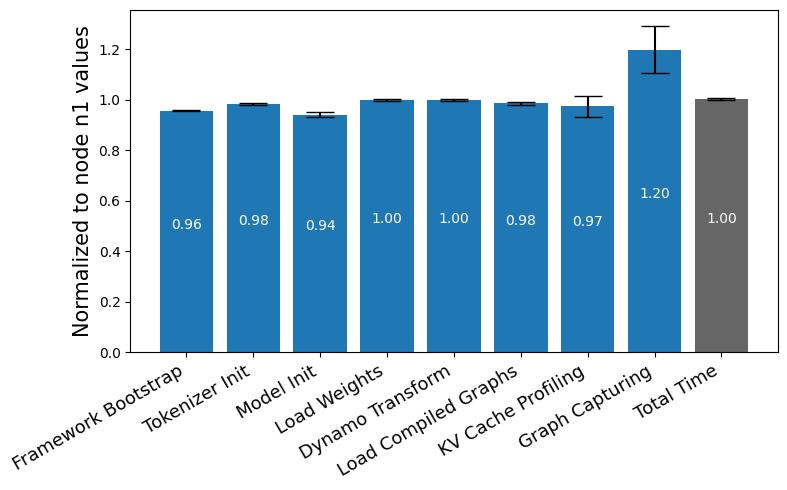

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))
from compare_2_avgs import compare_files

def compare_2_archs(filepath1, filepath2, verbosity, title, pdf_name, custom_bars=None):
    steps_map = {
        "framework_bootstrap": "Framework Bootstrap",
        "tokenizer_init": "Tokenizer Init",
        "model_init": "Model Init",
        "load_weights": "Load Weights",
        "dynamo_transform_time": "Dynamo Transform",
        "graph_compile_cached": "Load Compiled Graphs",
        "kv_cache_profiling": "KV Cache Profiling",
        "graph_capturing": "Graph Capturing",
        "actual_total_time": "Total Time",
    }
    
    output_results = compare_files(filepath1, filepath2, verbosity)
    print(output_results)
    if custom_bars:
        for key,values in custom_bars.items():
            output_results[key] = values
            
    # Order output_results based on steps_map order
    output_results = {k: output_results[k] for k in steps_map.keys() if k in output_results}
    
    

    steps = list(output_results.keys())
    avg_speedups = []
    stderr_speedups = []
    xticklabels = []
    colors = []
    for step in steps:
        if step in steps_map:
            speedups = [entry["speedup"] for entry in output_results[step]]
            avg_speedups.append(np.mean(speedups))
            stderr_speedups.append(stats.sem(speedups))
            xticklabels.append(steps_map[step])
            # Make the last bar (Total Time) red, others blue
            colors.append('#666666' if steps_map[step] == 'Total Time' else '#1f77b4')

    x = np.arange(len(xticklabels))
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(x, avg_speedups, yerr=stderr_speedups, capsize=10, color=colors, ecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=30, ha='right', fontsize=13)
    ax.set_ylabel(title, fontsize=15)

    # Annotate each bar with its value
    for bar, value in zip(bars, avg_speedups):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{value:.2f}", ha='center', va='bottom', fontsize=10, color='white')

    plt.tight_layout()
    plt.savefig(
        f"figures/{pdf_name}",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()
    
    
h100_filepath = "examples/model_size/avg_comparison_results.json"
l40s_filepath = "../node5/examples/model_size/avg_comparison_results.json"
verbosity = None
title = "Normalized to node n1 values"
pdf_name = "h100-vs-l40s.pdf"
# These numbers are generated from comparing node7 model_size2
# and node5 model_size2.
custom_bars = {
    "framework_bootstrap": [
        {
            "model_name": "falcon-7b",
            "value1": 7.9296,
            "value2": 7.5878000000000005,
            "speedup": 0.9568956820016143
        },
        {
            "model_name": "llama2-13b-hf",
            "value1": 7.935200000000001,
            "value2": 7.599,
            "speedup": 0.9576318177235608
        },
        {
            "model_name": "llama2-7b-hf",
            "value1": 7.929000000000001,
            "value2": 7.5962,
            "speedup": 0.9580274940093326
        },
        {
            "model_name": "llama3-3b",
            "value1": 7.962400000000001,
            "value2": 7.6138,
            "speedup": 0.9562192303827991
        },
        {
            "model_name": "qwen-0.5b",
            "value1": 7.9778,
            "value2": 7.6129999999999995,
            "speedup": 0.9542731078743513
        },
        {
            "model_name": "qwen-14b",
            "value1": 7.976800000000002,
            "value2": 7.614200000000001,
            "speedup": 0.9545431752081035
        },
        {
            "model_name": "qwen-1.8b",
            "value1": 7.9597999999999995,
            "value2": 7.6398,
            "speedup": 0.9597979848739919
        },
        {
            "model_name": "qwen-4b",
            "value1": 7.979,
            "value2": 7.6088,
            "speedup": 0.953603208422108
        },
        {
            "model_name": "qwen-7b",
            "value1": 7.9696,
            "value2": 7.6234,
            "speedup": 0.9565599277253564
        },
        {
            "model_name": "yi-6b",
            "value1": 8.01,
            "value2": 7.6222,
            "speedup": 0.9515855181023721
        },
        {
            "model_name": "yi-9b",
            "value1": 7.9571999999999985,
            "value2": 7.6248000000000005,
            "speedup": 0.9582265118383353
        }
    ],
}
compare_2_archs(h100_filepath, l40s_filepath, verbosity, title, pdf_name, custom_bars)

### Figure 11: Impact of Different CPU (Node 7 vs t1 vs t2)

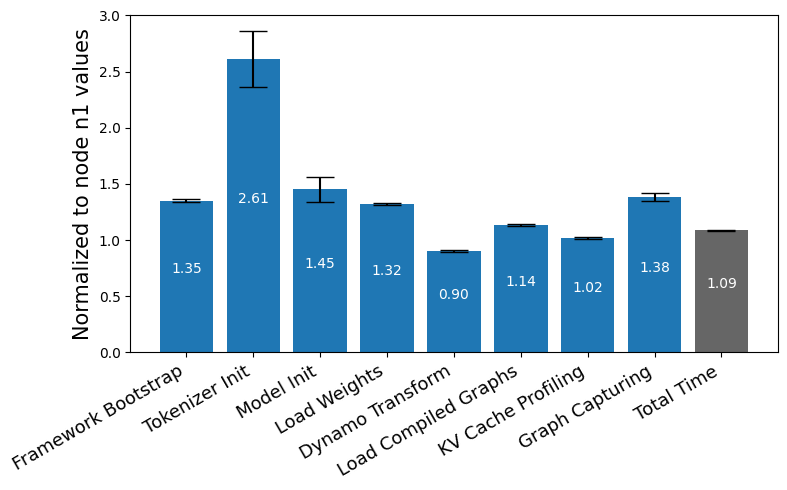

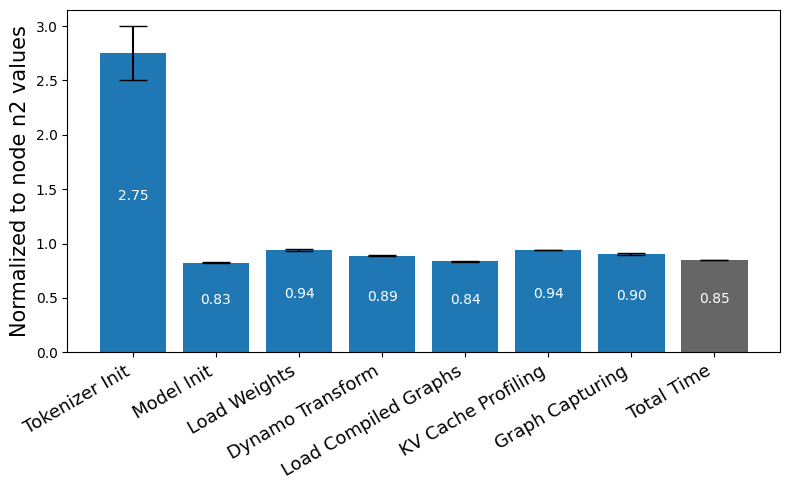

In [7]:
node7_filepath = "examples/model_size/avg_comparison_results.json"
t1_filepath = "../t1/examples/model_size/avg_comparison_results.json"
verbosity = None
title = "Normalized to node n1 values"
pdf_name = "node7-vs-t1.pdf"
# These numbers are generated from comparing node7 model_size2
# and t1 model_size3.
custom_bars = { "framework_bootstrap": [
        {
            "model_name": "falcon-7b",
            "value1": 7.9296,
            "value2": 10.619799999999998,
            "speedup": 1.339260492332526
        },
        {
            "model_name": "llama2-13b-hf",
            "value1": 7.935200000000001,
            "value2": 10.441199999999998,
            "speedup": 1.315808045165843
        },
        {
            "model_name": "llama2-7b-hf",
            "value1": 7.929000000000001,
            "value2": 10.620800000000001,
            "speedup": 1.339487955606003
        },
        {
            "model_name": "llama3-3b",
            "value1": 7.962400000000001,
            "value2": 10.6392,
            "speedup": 1.3361800462172209
        },
        {
            "model_name": "qwen-0.5b",
            "value1": 7.9778,
            "value2": 10.8308,
            "speedup": 1.3576173882524003
        },
        {
            "model_name": "qwen-14b",
            "value1": 7.976800000000002,
            "value2": 10.747,
            "speedup": 1.3472821181426133
        },
        {
            "model_name": "qwen-1.8b",
            "value1": 7.9597999999999995,
            "value2": 10.775599999999997,
            "speedup": 1.3537526068494181
        },
        {
            "model_name": "qwen-4b",
            "value1": 7.979,
            "value2": 10.7632,
            "speedup": 1.3489409700463717
        },
        {
            "model_name": "qwen-7b",
            "value1": 7.9696,
            "value2": 10.868200000000002,
            "speedup": 1.3637070869303356
        },
        {
            "model_name": "yi-6b",
            "value1": 8.01,
            "value2": 11.4878,
            "speedup": 1.4341822721598003
        },
        {
            "model_name": "yi-9b",
            "value1": 7.9571999999999985,
            "value2": 10.6536,
            "speedup": 1.3388629166038308
        }
    ]
}
compare_2_archs(node7_filepath, t1_filepath, verbosity, title, pdf_name, custom_bars)

node5_filepath = "../node5/examples/model_size/avg_comparison_results.json"
t2_filepath = "../t2/examples/model_size/avg_comparison_results.json"
verbosity = None
title = "Normalized to node n2 values"
pdf_name = "node5-vs-t2.pdf"
compare_2_archs(node5_filepath, t2_filepath, verbosity, title, pdf_name)

### Impact of CPU workload

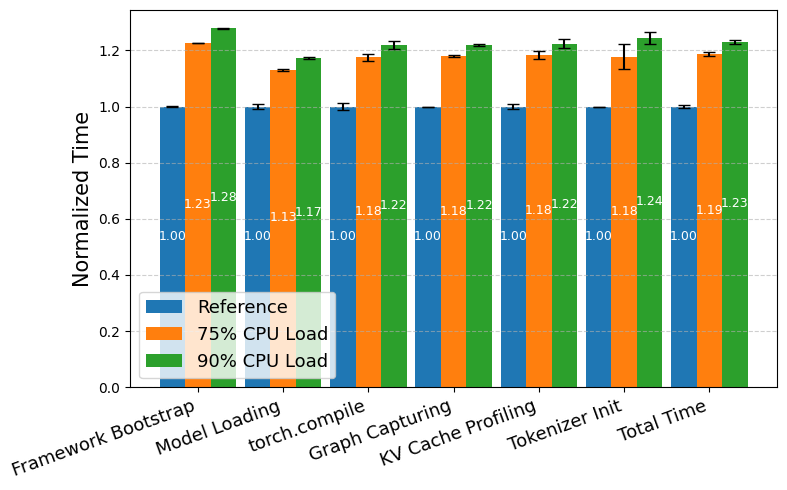

In [78]:
import numpy as np
import matplotlib.pyplot as plt

path = "./examples/cpu_load/iterations/"
model_labels = ["llama2-13b-hf", "qwen-4b"]
filename = "cpu_load"

default_data = parse_data(path, model_labels, "workload_0")
workload10_data = parse_data(path, model_labels, "workload_10")
workload25_data = parse_data(path, model_labels, "workload_25")
workload50_data = parse_data(path, model_labels, "workload_50")
workload75_data = parse_data(path, model_labels, "workload_75")
workload90_data = parse_data(path, model_labels, "workload_90")

dicts = [default_data, workload75_data, workload90_data]
labels = ['Reference', '75% CPU Load', '90% CPU Load']

steps_map = {
    "framework_bootstrap": "Framework Bootstrap",
    "model_loading": "Model Loading",
    "torch.compile": "torch.compile",
    "graph_capturing": "Graph Capturing",
    "kv_cache_profiling": "KV Cache Profiling",
    "tokenizer_init": "Tokenizer Init",
    "actual_total_time": "Total Time",
} 

# --- Compute mean and stderr ---
steps = steps_map.keys()
means = []
stderrs = []

for d in dicts:
    d_means = []
    d_stds = []
    for step in steps:
        values = [x for x in d[model_labels[0]][step] if x is not None]
        mean = np.mean(values)
        stderr = np.std(values, ddof=1) / np.sqrt(len(values))
        d_means.append(mean)
        d_stds.append(stderr)
    means.append(d_means)
    stderrs.append(d_stds)

# --- Normalize by reference means ---
ref_means = np.array(means[0])
norm_means = [np.array(m) / ref_means for m in means]
norm_stderrs = [np.array(s) / ref_means for s in stderrs]

# --- Plot ---
x = np.arange(len(steps))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(len(dicts)):
    bars = ax.bar(x + i * width, norm_means[i], width, yerr=norm_stderrs[i], label=labels[i], capsize=4)
    for bar, val in zip(bars, norm_means[i]):
            ax.annotate(f"{val:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color="white")

ax.set_xticks(x + width)
ax.set_xticklabels([steps_map[s] for s in steps], rotation=20, ha='right', fontsize=13)
ax.set_ylabel('Normalized Time', fontsize=15)
ax.legend(fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(
    f"figures/{filename}.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Figure 12: Impact of SSD

{'tokenizer_init': [{'model_name': 'falcon-7b', 'value1': 0.398, 'value2': 0.396, 'speedup': 0.9949748743718593}, {'model_name': 'llama2-13b-hf', 'value1': 0.376, 'value2': 0.35, 'speedup': 0.9308510638297872}, {'model_name': 'llama2-7b-hf', 'value1': 0.37000000000000005, 'value2': 0.336, 'speedup': 0.908108108108108}, {'model_name': 'llama3-3b', 'value1': 0.512, 'value2': 0.5700000000000001, 'speedup': 1.11328125}, {'model_name': 'qwen-0.5b', 'value1': 0.616, 'value2': 0.534, 'speedup': 0.8668831168831169}, {'model_name': 'qwen-14b', 'value1': 0.512, 'value2': 0.502, 'speedup': 0.98046875}, {'model_name': 'qwen-1.8b', 'value1': 0.508, 'value2': 0.508, 'speedup': 1.0}, {'model_name': 'qwen-4b', 'value1': 0.516, 'value2': 0.49000000000000005, 'speedup': 0.9496124031007752}, {'model_name': 'qwen-7b', 'value1': 0.54, 'value2': 0.508, 'speedup': 0.9407407407407407}, {'model_name': 'yi-6b', 'value1': 0.44799999999999995, 'value2': 0.442, 'speedup': 0.986607142857143}, {'model_name': 'yi-9b'

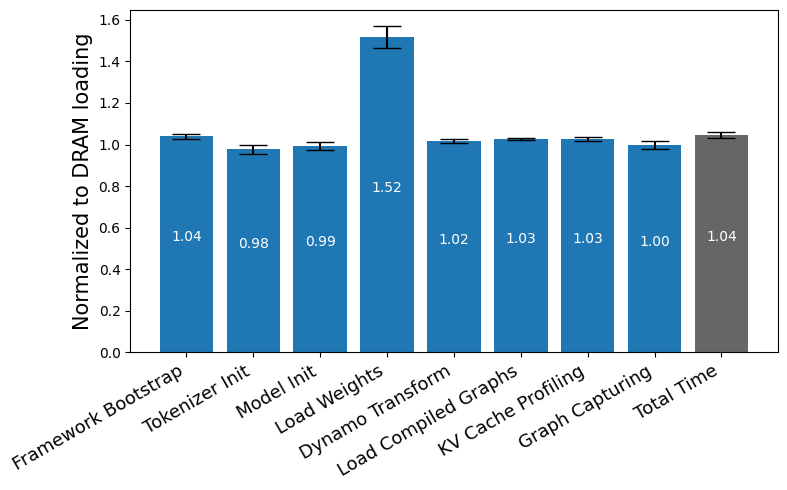

In [2]:
t1_filepath = "../t1/examples/model_size2/avg_comparison_results.json"
t1_ssd_filepath = "../t1/examples/ssd2/avg_comparison_results.json"
verbosity = None
title = "Normalized to DRAM loading"
pdf_name = "impact-of-ssd.pdf"
custom_bars = {
    "framework_bootstrap": [
        {
            "model_name": "falcon-7b",
            "value1": 10.619799999999998,
            "value2": 12.023799999999998,
            "speedup": 1.1322058795834196
        },
        {
            "model_name": "llama2-13b-hf",
            "value1": 10.441199999999998,
            "value2": 10.880399999999998,
            "speedup": 1.0420641305597058
        },
        {
            "model_name": "llama2-7b-hf",
            "value1": 10.620800000000001,
            "value2": 11.011,
            "speedup": 1.0367392286833381
        },
        {
            "model_name": "llama3-3b",
            "value1": 10.6392,
            "value2": 11.064800000000002,
            "speedup": 1.0400030077449434
        },
        {
            "model_name": "qwen-0.5b",
            "value1": 10.8308,
            "value2": 11.305399999999999,
            "speedup": 1.0438194777855743
        },
        {
            "model_name": "qwen-14b",
            "value1": 10.747,
            "value2": 11.157599999999999,
            "speedup": 1.0382060109798081
        },
        {
            "model_name": "qwen-1.8b",
            "value1": 10.775599999999997,
            "value2": 11.184000000000001,
            "speedup": 1.0379004417387434
        },
        {
            "model_name": "qwen-4b",
            "value1": 10.7632,
            "value2": 11.1598,
            "speedup": 1.036847777612606
        },
        {
            "model_name": "qwen-7b",
            "value1": 10.868200000000002,
            "value2": 11.0632,
            "speedup": 1.0179422535470453
        },
        {
            "model_name": "yi-6b",
            "value1": 11.4878,
            "value2": 11.0968,
            "speedup": 0.9659638921290412
        },
        {
            "model_name": "yi-9b",
            "value1": 10.6536,
            "value2": 11.0868,
            "speedup": 1.0406623113313809
        }
    ]
}
compare_2_archs(t1_filepath, t1_ssd_filepath, verbosity, title, pdf_name, custom_bars)

#### Print how much loading weights is of total time

In [80]:
import numpy as np
import json

with open(t1_filepath, "r") as f:
    data = json.load(f)

loading_weights_times = np.array(data["data"]["load_weights"])
actual_total_times = np.array(data["data"]["actual_total_time"])

mean = np.mean(loading_weights_times / actual_total_times) * 100
print(f"Loading weights is {mean:.2f}% of total time on average.")

model_init_times = np.array(data["data"]["model_init"])
mean_init = np.mean(model_init_times)
print(f"Mean Model init is {mean_init:.2f} seconds.")

Loading weights is 7.41% of total time on average.
Mean Model init is 0.11 seconds.


### Figure 13: Impact of Loading Methods

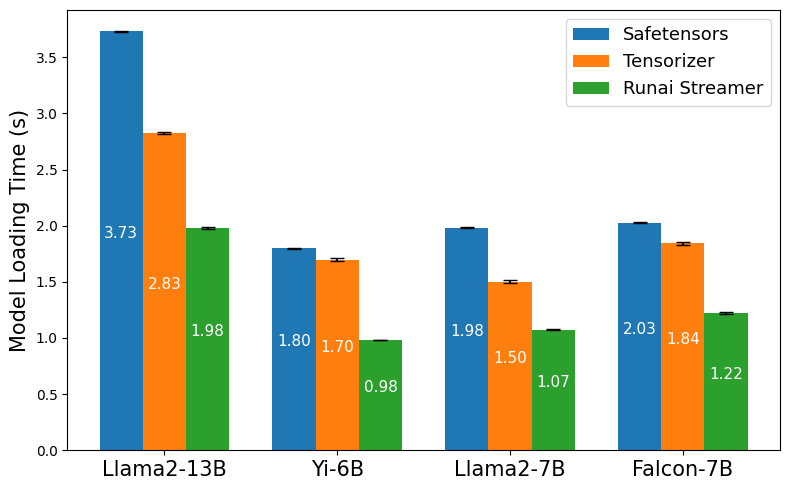

In [81]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

steps_map = {
    "tokenizer_init": "Tokenizer Init",
    "model_loading": "Model Loading",
    "torch.compile": "torch.compile",
    "graph_capturing": "Graph Capturing",
    "kv_cache_profiling": "KV Cache Profiling",
    "actual_total_time": "Total Time",
} 

# Configuration
base_dir = "./examples/loading_methods/iterations/"
num_iterations = 5
models = ["llama2-13b", "yi-6b", "llama2-7b", "falcon-7b"]
methods = ["safetensors", "tensorizer", "runai_streamer"]
metric = "model_loading"

# Collect data
results = {model: {method: [] for method in methods} for model in models}

for i in range(1, num_iterations + 1):
    path = os.path.join(base_dir, str(i), "comparison_results.json")
    with open(path, "r") as f:
        data = json.load(f)

    labels = data["labels"]
    values = data["data"][metric]

    for label, value in zip(labels, values):
        for model in models:
            if model in label:
                for method in methods:
                    if method in label:
                        results[model][method].append(value)

# Normalize each model's results relative to Safetensors
norm_results = {model: {method: [] for method in methods} for model in models}
for model in models:
    safetensors_values = np.array(results[model]["safetensors"])
    for method in methods:
        vals = np.array(results[model][method])
        norm_results[model][method] = vals # / safetensors_values  # element-wise normalization

# Compute mean and standard error for normalized values
means = []
stderrs = []
for model in models:
    for method in methods:
        vals = np.array(norm_results[model][method])
        means.append(np.mean(vals))
        stderrs.append(np.std(vals, ddof=1) / np.sqrt(len(vals)))

# Plot
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))
for i, method in enumerate(methods):
    method_means = means[i::3]
    method_stderrs = stderrs[i::3]
    bars = ax.bar(x + (i - 1)*width, method_means, width, yerr=method_stderrs,
           label=method.replace("_", " ").title(), capsize=5)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height / 2,
                f'{height:.2f}',
                ha='center', va='bottom',
                fontsize=11, color="white")
    

ax.set_ylabel(f"Model Loading Time (s)", fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels([m.title() for m in models], fontsize=15)
ax.legend(fontsize=13)

plt.tight_layout()
plt.savefig(
    f"figures/diff-loading-methods.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()


### Impact of uncached graphs

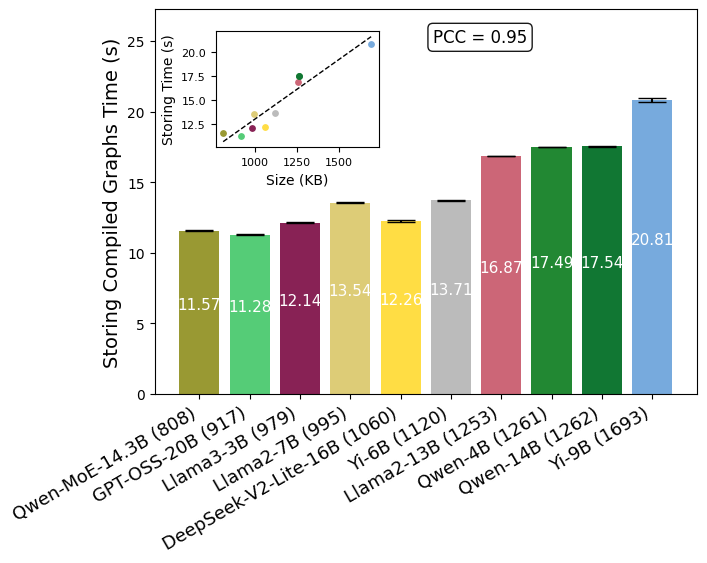

In [9]:
model_names_map = {
    "llama2-7b-hf": "Llama2-7B",
    "llama2-13b-hf": "Llama2-13B",
    "yi-6b": "Yi-6B",
    "yi-9b": "Yi-9B",
    "qwen-4b": "Qwen-4B",
    "qwen-14b": "Qwen-14B",
    "qwen-14.3b": "Qwen-MoE-14.3B",
    "llama3-3b": "Llama3-3B",
    "deepseek-v2-lite-16b": "DeepSeek-V2-Lite-16B",
    "gpt-oss-20b": "GPT-OSS-20B"
}

iterations_path = "examples/uncached_graphs/iterations"
sort_by = "model_size"
metric1 = "graph_compile_general_shape"
metric2 = "compiled_graph_sizes"
xlabel = ""
ylabel = "Storing Compiled Graphs Time (s)"
x2label = "Size (KB)"
y2label = "Storing Time (s)"
ylim_multiplier = 1.3
filename = "figures/store-graphs-results"
draw(model_names_map, iterations_path, sort_by, metric1, metric2, xlabel, ylabel, x2label, y2label, ylim_multiplier, filename)

In [83]:
import numpy as np

x1 = [11.28, 11.57, 12.26, 12.14, 13.71, 13.54, 17.49, 16.87, 17.54, 20.81]
x2 = [3.38, 2.89, 3.14, 3.30, 3.77, 3.62, 4.55, 4.64, 4.69, 5.66]

x1 = np.array(x1)
x2 = np.array(x2)

speedups = x1 / x2
avg_speedup = np.mean(speedups)
print(speedups)
print("Average speedup:", avg_speedup)

[3.33727811 4.00346021 3.9044586  3.67878788 3.63660477 3.74033149
 3.84395604 3.63577586 3.73987207 3.67667845]
Average speedup: 3.7197203477368808


### Impact of tmpfs

In [84]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os


def read_iterations(dir_name):
    files_contents = []
    for i in range (1, 6):
        iterations_path = os.path.join(dir_name, str(i))
        json_filepath = os.path.join(iterations_path, "comparison_results.json")
        with open(json_filepath, "r") as f:
            file_content = json.load(f)
            files_contents.append(file_content)
            
    return files_contents

def parse_data(path, labels, suffix):

    files_contents = []
    files_contents = read_iterations(path)
    data = {label: {} for label in labels}
    labels_indices = {label: 0 for label in labels}
    for i,label in enumerate(files_contents[0]["labels"]):
        for key in labels_indices.keys():
            if key.lower() in label and suffix in label:
                labels_indices[key] = i

    for i,file_content in enumerate(files_contents):
        for step, values in file_content["data"].items():
            for label,index in labels_indices.items():
                if step not in data[label]:
                    data[label][step] = []
                data[label][step].append(values[index])
              
    return data

def compare_versions(path, old_suffix, new_suffix, labels, filename):
    
    data_new = parse_data(path, labels, old_suffix)
    data_default = parse_data(path, labels, new_suffix)
    
    steps_map = {
        "model_loading": "Model Loading",
        "torch.compile": "torch.compile",
        "graph_capturing": "Graph Capturing",
        "kv_cache_profiling": "KV Cache Profiling",
        "tokenizer_init": "Tokenizer Init",
        "actual_total_time": "Total Time",
    } 

    models = list(data_new.keys())
    steps = steps_map.keys()

    ratios = {model: [] for model in models}
    errors = {model: [] for model in models}

    for step in steps:
        for model in models:
            vals = np.array(data_new[model][step], dtype=float)
            ref_vals = np.array(data_default[model][step], dtype=float)

            # Compute mean ratio and stderr
            ratio = vals.mean() / ref_vals.mean()
            stderr = ratio * np.sqrt((vals.std()/vals.mean())**2/len(vals) +
                                    (ref_vals.std()/ref_vals.mean())**2/len(ref_vals))
            ratios[model].append(ratio)
            errors[model].append(stderr)

    # --- Plot ---
    x = np.arange(len(steps))
    width = 0.3

    fig, ax = plt.subplots(figsize=(8, 5))

    for i, model in enumerate(models):
        bars = ax.bar(x + i*width, ratios[model], width, yerr=errors[model],
                    label=model, capsize=4)
        # Annotate each bar with its value
        for bar, val in zip(bars, ratios[model]):
            ax.annotate(f"{val:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color="white")

    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylabel("Normalized time", fontsize=15)
    ax.set_xticks(x + width)
    ax.set_xticklabels([steps_map[s] for s in steps], rotation=20, ha='right', fontsize=13)
    ax.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(
        f"figures/{filename}.pdf",
        format="pdf",
        bbox_inches="tight",
        transparent=True
    )
    plt.show()

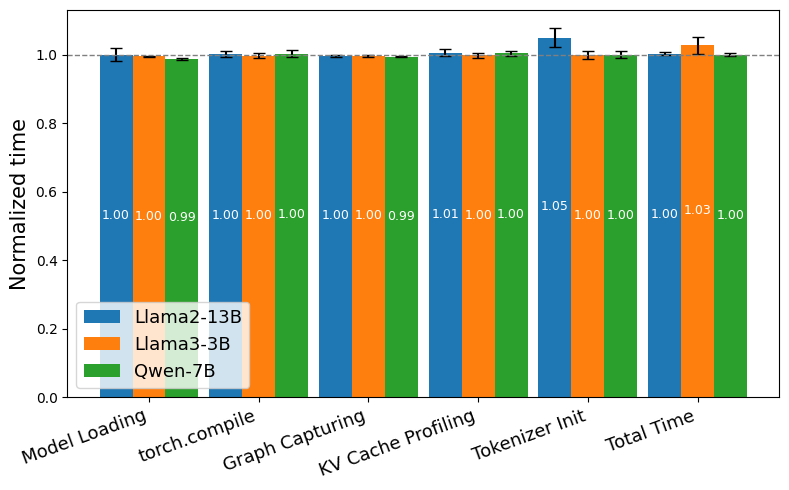

In [85]:
path = "./examples/tmpfs/iterations/"
labels = ["Llama2-13B", "Llama3-3B", "Qwen-7B"]
filename = "tmpfs"

compare_versions(path, "default", "tmpfs", labels, filename)

### Impact of PyTorch Versions

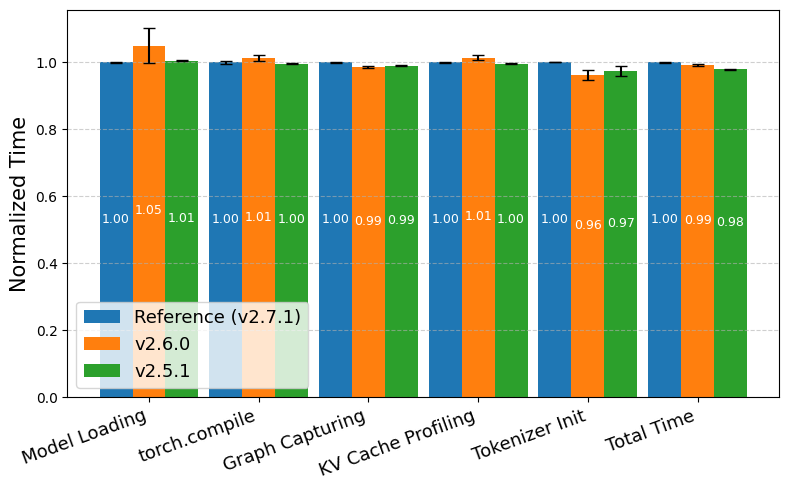

In [86]:
import numpy as np
import matplotlib.pyplot as plt

path = "./examples/pytorch_versions/iterations/"
model_labels = ["Yi-9B"]
filename = "pytorch"

default_data = parse_data(path, model_labels, "default")
torch2_6_0_data = parse_data(path, model_labels, "torch2.6.0")
torch2_5_1_data = parse_data(path, model_labels, "torch2.5.1")

dicts = [default_data, torch2_6_0_data, torch2_5_1_data]
labels = ['Reference (v2.7.1)', 'v2.6.0', 'v2.5.1']

steps_map = {
    "model_loading": "Model Loading",
    "torch.compile": "torch.compile",
    "graph_capturing": "Graph Capturing",
    "kv_cache_profiling": "KV Cache Profiling",
    "tokenizer_init": "Tokenizer Init",
    "actual_total_time": "Total Time",
} 

# --- Compute mean and stderr ---
steps = steps_map.keys()
means = []
stderrs = []

for d in dicts:
    d_means = []
    d_stds = []
    for step in steps:
        values = [x for x in d[model_labels[0]][step] if x is not None]
        mean = np.mean(values)
        stderr = np.std(values, ddof=1) / np.sqrt(len(values))
        d_means.append(mean)
        d_stds.append(stderr)
    means.append(d_means)
    stderrs.append(d_stds)

# --- Normalize by reference means ---
ref_means = np.array(means[0])
norm_means = [np.array(m) / ref_means for m in means]
norm_stderrs = [np.array(s) / ref_means for s in stderrs]

# --- Plot ---
x = np.arange(len(steps))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(len(dicts)):
    bars = ax.bar(x + i * width, norm_means[i], width, yerr=norm_stderrs[i], label=labels[i], capsize=4)
    for bar, val in zip(bars, norm_means[i]):
            ax.annotate(f"{val:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color="white")

ax.set_xticks(x + width)
ax.set_xticklabels([steps_map[s] for s in steps], rotation=20, ha='right', fontsize=13)
ax.set_ylabel('Normalized Time', fontsize=15)
ax.legend(fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(
    f"figures/pytorch-versions.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Different vLLM Params

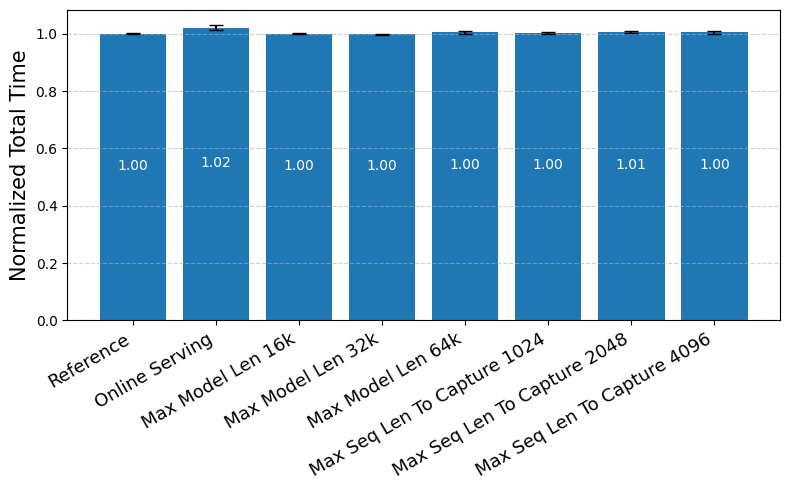

In [87]:
import numpy as np
import matplotlib.pyplot as plt

path = "./examples/vllm_params/iterations/"
model_labels = ["LLama3-3B"]
filename = "vllm-params"

offline_data = parse_data(path, model_labels, "offline-serving")
online_data = parse_data(path, model_labels, "online-serving")
max_model_len_16k_data = parse_data(path, model_labels, "max-model-len_16k")
max_model_len_32k_data = parse_data(path, model_labels, "max-model-len_32k")
max_model_len_64k_data = parse_data(path, model_labels, "max-model-len_64k")
max_model_seq_len_1024_data = parse_data(path, model_labels, "max-seq-len-to-capture_1024")
max_model_seq_len_2048_data = parse_data(path, model_labels, "max-seq-len-to-capture_2048")
max_model_seq_len_4096_data = parse_data(path, model_labels, "max-seq-len-to-capture_4096")

dicts = [
    offline_data,
    online_data,
    max_model_len_16k_data,
    max_model_len_32k_data,
    max_model_len_64k_data,
    max_model_seq_len_1024_data,
    max_model_seq_len_2048_data,
    max_model_seq_len_4096_data
]

labels = [
    "Reference",
    "Online Serving",
    "Max Model Len 16k",
    "Max Model Len 32k",
    "Max Model Len 64k",
    "Max Seq Len To Capture 1024",
    "Max Seq Len To Capture 2048",
    "Max Seq Len To Capture 4096",
]

means, stderrs = [], []
for d in dicts:
    vals = d[model_labels[0]]['actual_total_time']
    mean = np.mean(vals)
    stderr = np.std(vals, ddof=1) / np.sqrt(len(vals))
    means.append(mean)
    stderrs.append(stderr)

# --- Normalize relative to the first dict (reference) ---
ref_mean = means[0]
norm_means = [m / ref_mean for m in means]
norm_stderrs = [s / ref_mean for s in stderrs]

# --- Plot ---
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, norm_means, yerr=norm_stderrs, capsize=5)
for bar, val in zip(bars, norm_means):
    ax.annotate(f"{val:.2f}", 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color="white")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=13)
ax.set_ylabel("Normalized Total Time", fontsize=15)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(
    f"figures/vllm_params.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()


### Impact Of Containerization

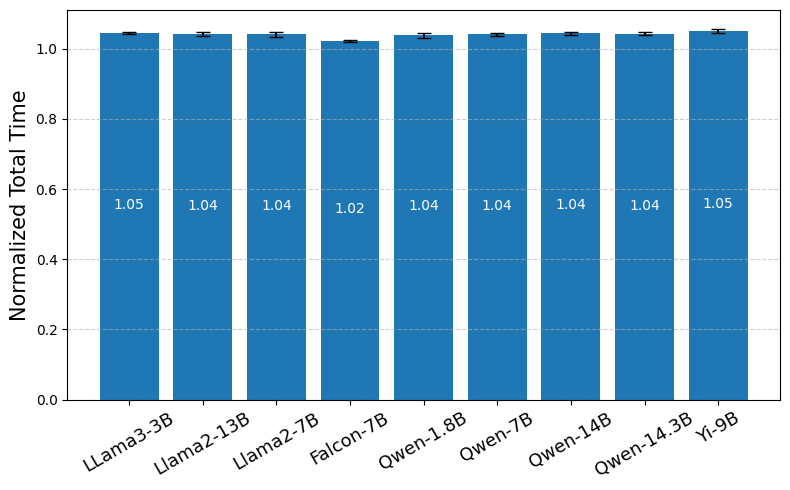

In [88]:
path = "./examples/docker_container/iterations/"
model_labels = ["LLama3-3B", "Llama2-13B", "Llama2-7B", "Falcon-7B", "Qwen-1.8B", "Qwen-7B", "Qwen-14B", "Qwen-14.3B", "Yi-9B"]

data_new = parse_data(path, model_labels, "container")
data_default = parse_data(path, model_labels, "default")

step = "actual_total_time"

models = list(data_new.keys())
ratios = []
stderr = []

for m in models:
    vals1 = np.array(data_new[m][step])
    vals2 = np.array(data_default[m][step])
    ratio = vals2 / vals1  # element-wise normalization
    ratios.append(np.mean(ratio))
    stderr.append(np.std(ratio, ddof=1) / np.sqrt(len(ratio)))  # standard error

# ---- Plot ----
plt.figure(figsize=(8, 5))
bars = plt.bar(models, ratios, yerr=stderr, capsize=5)
for bar, val in zip(bars, ratios):
    plt.annotate(f"{val:.2f}", 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color="white")

plt.ylabel('Normalized Total Time', fontsize=15)
plt.xticks(rotation=30, fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(
    f"figures/docker-container.pdf",
    format="pdf",
    bbox_inches="tight",
    transparent=True
)
plt.show()

### Tokenizer size vs vocab size

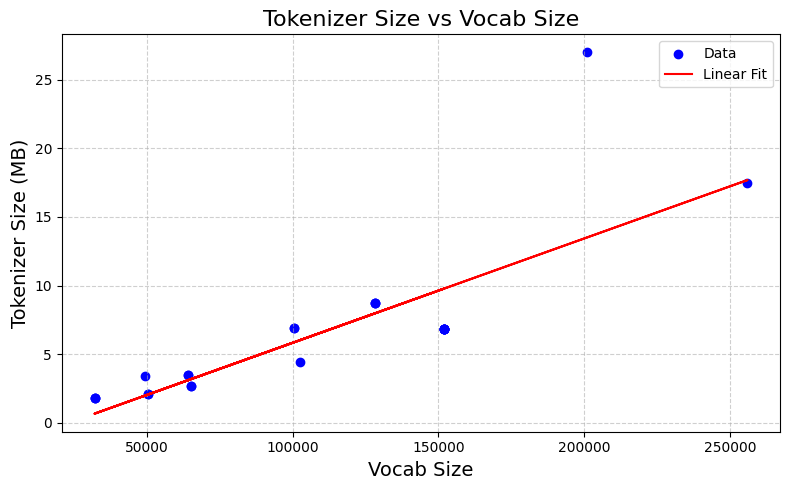

In [89]:
import json 
import matplotlib.pyplot as plt

model_configs = {}
with open("../../../vllm-profiling/models_config.json", "r") as f:
    model_configs = json.load(f)
    
tokenizer_sizes = [values["tokenizer_size"] for _,values in model_configs.items()]
vocab_sizes = [values["vocab_size"] for _,values in model_configs.items()]
model_names = [key for key, _ in model_configs.items()]

plt.figure(figsize=(8, 5))
plt.scatter(vocab_sizes, tokenizer_sizes, color='blue', label='Data')

# Fit linear regression
X = np.array(vocab_sizes).reshape(-1, 1)
y = np.array(tokenizer_sizes)
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

plt.plot(vocab_sizes, y_pred, color='red', label='Linear Fit')
plt.xlabel("Vocab Size", fontsize=14)
plt.ylabel("Tokenizer Size (MB)", fontsize=14)
plt.title("Tokenizer Size vs Vocab Size", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
# Annotate each point with its model name
# for i, name in enumerate(model_names):
#     plt.annotate(name, (vocab_sizes[i], tokenizer_sizes[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
plt.tight_layout()
plt.show()